In [1]:
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_vector
backend = BasicAer.get_backend('statevector_simulator')

# Task1 : Swap test

1) Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.


## Solution
parametric unitary operator:

$U_3(\theta,\phi,\lambda) = \begin{bmatrix} cos(\theta/2) & -e^{i\lambda}sin(\theta/2) \\  e^{i\phi} sin(\theta/2) & e^{i\lambda + i \phi}cos(\theta/2) \end{bmatrix}$

acted upon qubit in state |1>, gives:

$U_3 \begin{bmatrix} 0 \\ 1 \end{bmatrix} = \begin{bmatrix}-e^{i\lambda}sin(\theta/2) \\ e^{i\lambda + i \phi}cos(\theta/2)\end{bmatrix} $


#### U3 gate quantum circuit:-

In [2]:
theta, phi, lam = np.pi/3, np.pi/2, np.pi/2 #parameters for the parametric gate
qc = QuantumCircuit(1)
initial_state = [0,1]
qc.initialize(initial_state, 0)
qc.u(theta, phi, lam,0)
qc.draw() 

┌─────────────────┐┌────────────────┐
q_0: ┤ initialize(0,1) ├┤ U(π/3,π/2,π/2) ├
     └─────────────────┘└────────────────┘

In [3]:
job = execute(qc, backend)

print('final state vector for given parameters = ', job.result().get_statevector())

final state vector for given parameters =  [ 5.00000000e-01+0.j        -1.59086286e-16-0.8660254j]


In [4]:
analytical_answer = np.array([-np.exp(1j*lam)*np.sin(theta/2) , np.exp(1j*lam + 1j*phi)*np.cos(theta/2)])*(1j)
print('analytically expected answer = ', analytical_answer)

analytically expected answer =  [ 5.00000000e-01-3.06161700e-17j -1.06057524e-16-8.66025404e-01j]


**The final state vector computed using U3 gate quantum circuit matches the analytically expected answer**

#### parametric variational circuit and visualisation on Bloch sphere :-

In [5]:
# use variational circuit to get state vectors as function of theta, phi, lambda
def transform_1_qubit(theta, phi, lam):
    qc = QuantumCircuit(1)
    initial_state = [0,1]
    qc.initialize(initial_state, 0)
    qc.u(theta, phi, lam,0)
    job = execute(qc, backend)
    return job.result().get_statevector()

In [6]:
# generating random values of parameters
n=400
theta_arr = 2*np.pi*np.random.rand(n)
phi_arr = 2*np.pi*np.random.rand(n)
lam_arr = 2*np.pi*np.random.rand(n)


In [7]:
# Calculating state vectors for each parameter set.
fig=visualization.plot_bloch_multivector(initial_state)
final_state_vectors=np.zeros([n,3])
for i in range(n) :
    theta=theta_arr[i]
    phi=phi_arr[i]
    lam=lam_arr[i]
    final_state_vector=transform_1_qubit(theta,phi,lam)
    final_state_vector_cartesian = np.array(visualization.utils._bloch_multivector_data(final_state_vector))
    final_state_vectors[i,:] = final_state_vector_cartesian

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

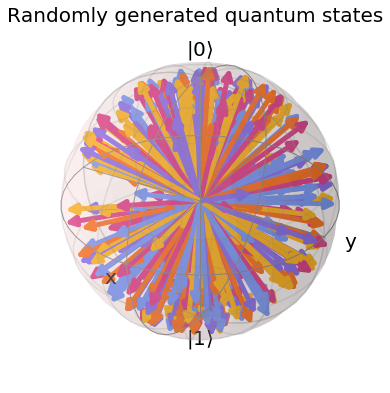

In [8]:
# visualizing the final state vectors on Bloch Sphere
plot_bloch_vector(final_state_vectors,title='Randomly generated quantum states')

**State vectors are filling up the Bloch Sphere, hence the variational circuit is working correctly.**

 2) Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.
 ## Solution
 Swap test returns, 

$Prob(ancilla = |0>) = \frac{1}{2} + \frac{1}{2} |<\Phi|\Psi>|^2$ 

Therefore $=1$ when $\Phi$ is parallel or antiparallel to $\Psi$ and $=0$ if $\Phi$ and $\Psi$ are orthogonal

In [9]:
theta, phi, lam = 0,np.pi/3,np.pi/6 #parameters for phi state
theta_var, phi_var, lam_var = 0,np.pi/3,np.pi/6 #parameters for psi state

#### Swap test Simulation :-

In [10]:
q_simulator = BasicAer.get_backend('qasm_simulator')
register_size = 1

qr_psi = QuantumRegister(register_size, 'psi')  
qr_phi = QuantumRegister(register_size, 'phi')  
qr_ancilla = QuantumRegister(1, 'ancilla')
cequal = ClassicalRegister(1, 'equal')

circuit = QuantumCircuit()

circuit.add_register(qr_psi)
circuit.add_register(qr_phi)
circuit.add_register(qr_ancilla)
circuit.add_register(cequal)


def cswap(circuit, ctrl, q1, q2) -> None:
    for i in range(len(q1)):
        # Controlled swap
        circuit.ccx(ctrl, q1[i], q2[i])
        circuit.ccx(ctrl, q2[i], q1[i])
        circuit.ccx(ctrl, q1[i], q2[i])
        
#Swap test circuit
def equality_test(circuit, ancilla, q1, q2, classical_register) -> None:
    circuit.h(ancilla[0])
    cswap(circuit, ancilla[0], q1, q2)
    circuit.h(ancilla[0])
    circuit.measure(ancilla[0], classical_register[0])

#initialise phi and psi states

circuit.initialize([1,0], 0)
circuit.u(theta, phi, lam,0)
circuit.initialize([1,0], 1)
circuit.u(theta_var, phi_var, lam_var,1)

equality_test(circuit, qr_ancilla, qr_psi, qr_phi, cequal)


In [11]:
circuit.draw()

┌─────────────────┐┌──────────────┐     ┌───┐             
    psi_0: ┤ initialize(1,0) ├┤ U(0,π/3,π/6) ├──■──┤ X ├──■──────────
           ├─────────────────┤├──────────────┤┌─┴─┐└─┬─┘┌─┴─┐        
    phi_0: ┤ initialize(1,0) ├┤ U(0,π/3,π/6) ├┤ X ├──■──┤ X ├────────
           └──────┬───┬──────┘└──────────────┘└─┬─┘  │  └─┬─┘┌───┐┌─┐
ancilla_0: ───────┤ H ├─────────────────────────■────■────■──┤ H ├┤M├
                  └───┘                                      └───┘└╥┘
  equal: 1/════════════════════════════════════════════════════════╩═
                                                                   0

In [12]:
num_shots = 2048
res_qasm = execute([circuit], q_simulator, shots=num_shots).result()
p_0 = res_qasm.get_counts()['0']/num_shots
print(p_0)

1.0


**As we took same parameters for the $\Phi$ and $\Psi$ states, we got prob(anicilla = 0) = 1. Hence, the Swap test circuit above is working fine.** 

#### Now we reconstruct a state(randomnly generated) using swap test with variational quantum eigen solver, which basically finds the parameters that reduces the cost :-

We estimate cost as the negative of swap test output for the original and reconstructed state. minimum cost = -1, i.e when the two states are equal.


In [13]:
def objective_function(params):
    theta_var, phi_var, lam_var = params
    q_simulator = BasicAer.get_backend('qasm_simulator')
    register_size = 1

    qr_psi = QuantumRegister(register_size, 'psi')  
    qr_phi = QuantumRegister(register_size, 'phi')  
    qr_ancilla = QuantumRegister(1, 'ancilla')
    cequal = ClassicalRegister(1, 'equal')

    circuit = QuantumCircuit()

    circuit.add_register(qr_psi)
    circuit.add_register(qr_phi)
    circuit.add_register(qr_ancilla)
    circuit.add_register(cequal)

    circuit.initialize([1,0], 0)
    circuit.u(theta, phi, lam,0)
    circuit.initialize([1,0], 1)
    circuit.u(theta_var, phi_var, lam_var,1)

    equality_test(circuit, qr_ancilla, qr_psi, qr_phi, cequal)
    num_shots = 2048
    res_qasm = execute([circuit], q_simulator, shots=num_shots).result()
    p_0 = res_qasm.get_counts()['0']/num_shots
    cost = -p_0
    return cost

In [35]:
from qiskit.aqua.components.optimizers import COBYLA
# randomly generate a state
theta, phi, lam = 2*np.pi*np.random.rand(3)
optimizer = COBYLA(maxiter=1e6, tol=1e-6)
# initialise parameters for the reconstructed state
params = 2*np.pi*np.random.rand(3)
#minimize the cost
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)


In [36]:
# parameters at the minimum cost
theta_recons, phi_recons, lam_recons = ret[0]
print('randomnly generated state parameters:', theta, phi, lam)
print( 'its reconstructed state parameters:',theta_recons, phi_recons, lam_recons)


randomnly generated state parameters: 5.8365502322729 2.4389975625719726 3.826656016165221
its reconstructed state parameters: 0.4336055248398273 -0.6353559482255939 3.1645612621531174


In [37]:
# get the corresponding state vectors from the parameters
original_qc=transform_1_qubit(theta, phi, lam)
recons_qc = transform_1_qubit(theta_recons, phi_recons, lam_recons)
complex_inner_product = np.abs(np.conjugate(original_qc)*recons_qc).sum()**2
print('randomnly generated original state: ' , original_qc)
print('its reconstruction using VQE Swap test: ',  recons_qc)
print('inner product of the original and reconstructed state: ',complex_inner_product )

randomnly generated original state:  [ 0.22146599+0.j         -0.7442169 +0.63015397j]
its reconstruction using VQE Swap test:  [ 0.21510834+0.j         -0.78601888+0.57957116j]
inner product of the original and reconstructed state:  0.9999575583067101


**The reconstructed state is almost equal to the original one, also seen in the bloch sphere figures below**

In [38]:
#convert the state vectors in cartesian representation and visualise on bloch sphere
original_qc_cartesian = np.array(visualization.utils._bloch_multivector_data(original_qc))
recons_qc_cartesian = np.array(visualization.utils._bloch_multivector_data(recons_qc))


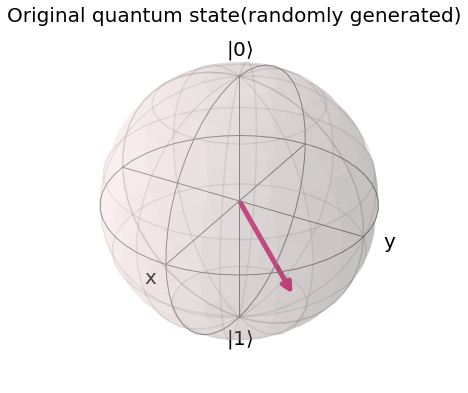

In [39]:
plot_bloch_vector(original_qc_cartesian,title='Original quantum state(randomly generated)')


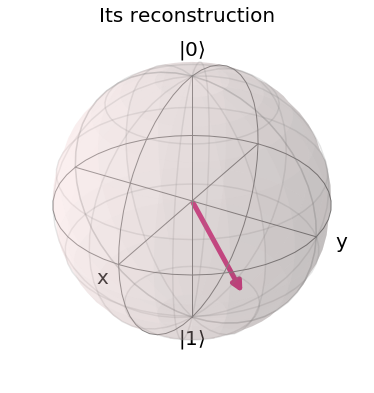

In [40]:
plot_bloch_vector(recons_qc_cartesian,title='Its reconstruction')


3) Suppose you are given with a random state, made by N qubits, for which you only know that it is a product state and each of the qubits are in the state |0> or |1>. By product state we mean that it can be written as the product of single qubit states, without the need to do any summation. Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.


### Solution
The input product state which is to be reconstructed is essentially a sequence of 0s and 1s.

**We perform both qubit by qubit swap test simulation or Multi-Qubit swap tests, to reconstruct the product state.**

##### Qubit by Qubit swap test:

$\Psi$ is the given product state, or arbitrary number of qubits, say N. However, $\Phi$ is take to be $|0>^N$. The following swap test checks for each qubit whether it is equal to |0> or not.

In [41]:
input_product_state='1011' #any sequence of zeros and ones, max length = 8

q_simulator = BasicAer.get_backend('qasm_simulator')
register_size = len(input_product_state)

qr_psi = QuantumRegister(register_size, 'psi')  
qr_phi = QuantumRegister(register_size, 'phi')  
qr_ancilla = QuantumRegister(register_size, 'ancilla')
cequal = ClassicalRegister(register_size, 'equal')

circuit = QuantumCircuit()

circuit.add_register(qr_psi)
circuit.add_register(qr_phi)
circuit.add_register(qr_ancilla)
circuit.add_register(cequal)


def cswap(circuit, ctrl, q1, q2) -> None:
    circuit.ccx(ctrl, q1, q2)
    circuit.ccx(ctrl, q2, q1)
    circuit.ccx(ctrl, q1, q2)

def equality_test(circuit, ancilla, q1, q2, classical_register) -> None:
    circuit.h(ancilla)
    cswap(circuit, ancilla, q1, q2)
    circuit.h(ancilla)
    circuit.measure(ancilla, classical_register)
    
# initialize the qubits
def str2qubit(str_qubit):
    if str_qubit == '0':
        return [1,0]
    else :
        return [0,1]
    
[circuit.initialize(str2qubit(input_product_state[i]), i) for i in range(register_size)]
[circuit.initialize([1,0], register_size+i) for i in range(register_size)]


[equality_test(circuit, qr_ancilla[i], qr_psi[i], qr_phi[i], cequal[i]) for i in range(register_size)]

res_qasm = execute([circuit], q_simulator, shots=2048).result()
counts = res_qasm.get_counts(circuit)


In [42]:
circuit.draw()

┌─────────────────┐                    ┌───┐                    »
    psi_0: ┤ initialize(0,1) ├──■─────────────────┤ X ├─────────────────■──»
           ├─────────────────┤  │                 └─┬─┘┌───┐            │  »
    psi_1: ┤ initialize(1,0) ├──┼────■──────────────┼──┤ X ├────────────┼──»
           ├─────────────────┤  │    │              │  └─┬─┘┌───┐       │  »
    psi_2: ┤ initialize(0,1) ├──┼────┼────■─────────┼────┼──┤ X ├───────┼──»
           ├─────────────────┤  │    │    │         │    │  └─┬─┘┌───┐  │  »
    psi_3: ┤ initialize(0,1) ├──┼────┼────┼────■────┼────┼────┼──┤ X ├──┼──»
           ├─────────────────┤┌─┴─┐  │    │    │    │    │    │  └─┬─┘┌─┴─┐»
    phi_0: ┤ initialize(1,0) ├┤ X ├──┼────┼────┼────■────┼────┼────┼──┤ X ├»
           ├─────────────────┤└─┬─┘┌─┴─┐  │    │    │    │    │    │  └─┬─┘»
    phi_1: ┤ initialize(1,0) ├──┼──┤ X ├──┼────┼────┼────■────┼────┼────┼──»
           ├─────────────────┤  │  └─┬─┘┌─┴─┐  │    │    │    │    │    │  »
    phi_2: ┤ initialize(1,0) ├──┼────┼──┤ X ├──┼────┼────┼────■────┼────┼──»
           ├─────────────────┤  │    │  └─┬─┘┌─┴─┐  │    │    │    │    │  »
    phi_3: ┤ initialize(1,0) ├──┼────┼────┼──┤ X ├──┼────┼────┼────■────┼──»
           └──────┬───┬──────┘  │    │    │  └─┬─┘  │    │    │    │    │  »
ancilla_0: ───────┤ H ├─────────■────┼────┼────┼────■────┼────┼────┼────■──»
                  ├───┤              │    │    │         │    │    │       »
ancilla_1: ───────┤ H ├──────────────■────┼────┼─────────■────┼────┼───────»
                  ├───┤                   │    │              │    │       »
ancilla_2: ───────┤ H ├───────────────────■────┼──────────────■────┼───────»
                  ├───┤                        │                   │       »
ancilla_3: ───────┤ H ├────────────────────────■───────────────────■───────»
                  └───┘                                                    »
  equal: 4/════════════════════════════════════════════════════════════════»
                                                                           »
«                                           
«    psi_0: ────────────────────────────────
«                                           
«    psi_1: ──■─────────────────────────────
«             │                             
«    psi_2: ──┼────■────────────────────────
«             │    │                        
«    psi_3: ──┼────┼────■───────────────────
«             │    │    │                   
«    phi_0: ──┼────┼────┼───────────────────
«           ┌─┴─┐  │    │                   
«    phi_1: ┤ X ├──┼────┼───────────────────
«           └─┬─┘┌─┴─┐  │                   
«    phi_2: ──┼──┤ X ├──┼───────────────────
«             │  └─┬─┘┌─┴─┐                 
«    phi_3: ──┼────┼──┤ X ├─────────────────
«             │    │  └─┬─┘┌───┐┌─┐         
«ancilla_0: ──┼────┼────┼──┤ H ├┤M├─────────
«             │    │    │  ├───┤└╥┘┌─┐      
«ancilla_1: ──■────┼────┼──┤ H ├─╫─┤M├──────
«                  │    │  ├───┤ ║ └╥┘┌─┐   
«ancilla_2: ───────■────┼──┤ H ├─╫──╫─┤M├───
«                       │  ├───┤ ║  ║ └╥┘┌─┐
«ancilla_3: ────────────■──┤ H ├─╫──╫──╫─┤M├
«                          └───┘ ║  ║  ║ └╥┘
«  equal: 4/═════════════════════╩══╩══╩══╩═
«                                0  1  2  3

In [43]:
# manipulating the counts dictionary to get the probability of each ancilla = 0
keys=(list(res_qasm.get_counts().keys()))
p_0 = np.zeros(register_size)
for key in keys:
    loc=np.where(np.array(list(key)).astype(int)==0)[0]
    p_0[loc]+= counts[key]/2048
p_0 = np.flip(p_0)

In [44]:
print('Output of qubit by qubit swap test, Prob(ancilla = 0): ', p_0)

Output of qubit by qubit swap test, Prob(ancilla = 0):  [0.51660156 1.         0.50439453 0.5       ]


**We notice that the probabilities is either ~1 (telling that qubit is |0>) or ~0.5 (telling that qubit is |1>), as expected.**

In [45]:
# reconstruction of the state, wherever p(ancilla = 0) is not equal to 1(<0.9), the qubit is in 0 state.
recons_state = (p_0<0.9).astype(int).astype(str)

In [46]:
print('input product state: ',  list(input_product_state))
print('its reconstruction', list(recons_state))

input product state:  ['1', '0', '1', '1']
its reconstruction ['1', '0', '1', '1']


**Hence the input product state is reconstructed using qubit by qubit swap test. In principle the state could also be reconstructed by just measuring the individual qubits.**

Here we used N ancillas and fixed the $|\Phi>$ state for doing qubit by qubit swap test, where N is the number of qubits in the product state.

**Alternatively, we can also perform multi-qubit swap test, repeatedly, by changing the $|\Phi>$ randomnly on the $2^N$ grid, using just one ancilla, which is done below:-**

In [47]:
input_product_state='1011' #any sequence of zeros and ones, max length = 8

def cswap(circuit, ctrl, q1, q2) -> None:
    for i in range(len(q1)):
        # Controlled swap
        circuit.ccx(ctrl, q1[i], q2[i])
        circuit.ccx(ctrl, q2[i], q1[i])
        circuit.ccx(ctrl, q1[i], q2[i])
        
#Swap test circuit
def equality_test(circuit, ancilla, q1, q2, classical_register) -> None:
    circuit.h(ancilla[0])
    cswap(circuit, ancilla[0], q1, q2)
    circuit.h(ancilla[0])
    circuit.measure(ancilla[0], classical_register[0])
    
# initialize the qubits
def str2qubit(str_qubit):
    if str_qubit == '0':
        return [1,0]
    else :
        return [0,1]

def swap_test_phi(guess_product_state):
    q_simulator = BasicAer.get_backend('qasm_simulator')
    register_size = len(input_product_state)

    qr_psi = QuantumRegister(register_size, 'psi')  
    qr_phi = QuantumRegister(register_size, 'phi')  
    qr_ancilla = QuantumRegister(1, 'ancilla')
    cequal = ClassicalRegister(1, 'equal')

    circuit = QuantumCircuit()

    circuit.add_register(qr_psi)
    circuit.add_register(qr_phi)
    circuit.add_register(qr_ancilla)
    circuit.add_register(cequal)

    [circuit.initialize(str2qubit(input_product_state[i]), i) for i in range(register_size)]
    [circuit.initialize(str2qubit(guess_product_state[i]), register_size+i) for i in range(register_size)]


    equality_test(circuit, qr_ancilla, qr_psi, qr_phi, cequal)
    num_shots = 2048
    res_qasm = execute([circuit], q_simulator, shots=num_shots).result()
    p_0 = res_qasm.get_counts(circuit)['0']/num_shots
    return p_0

In [48]:
from itertools import product  
# calculate all possible states for the N qubit product state
possible_states = np.array(list(product([0,1],repeat = register_size))).astype(str)
print('possible product states of %d qubits: \n'%register_size, possible_states)

possible product states of 4 qubits: 
 [['0' '0' '0' '0']
 ['0' '0' '0' '1']
 ['0' '0' '1' '0']
 ['0' '0' '1' '1']
 ['0' '1' '0' '0']
 ['0' '1' '0' '1']
 ['0' '1' '1' '0']
 ['0' '1' '1' '1']
 ['1' '0' '0' '0']
 ['1' '0' '0' '1']
 ['1' '0' '1' '0']
 ['1' '0' '1' '1']
 ['1' '1' '0' '0']
 ['1' '1' '0' '1']
 ['1' '1' '1' '0']
 ['1' '1' '1' '1']]


In [49]:
# perform swap test for all the possible states
p_0 = np.zeros(2**register_size)
for i in range(2**register_size):
    p_0[i] = swap_test_phi(possible_states[i,:])

In [50]:
# extract the state which gives prob(ancilla = 0) ~ 1
recons_state = possible_states[p_0>0.95,:][0]
print('input product state: ',  list(input_product_state))
print('its reconstruction', recons_state)

input product state:  ['1', '0', '1', '1']
its reconstruction ['1' '0' '1' '1']


**Hence the input product state can also be reconstructed by performing multi-qubit swap tests, by changing $\Phi$ on $2^N$ grid**